# EKF Orbit Determination with Simulated GNSS

This notebook demonstrates **Extended Kalman Filter (EKF)** orbit determination using `astrojax`. We:

1. Propagate a "truth" LEO orbit with a high-fidelity force model (20×20 gravity, drag, SRP, third-body Sun/Moon)
2. Generate noisy GNSS position+velocity measurements along the truth trajectory
3. Run an EKF with a **deliberately simpler** dynamics model (5×5 gravity only) to estimate the orbit
4. Visualize position/velocity errors, covariance bounds, and measurement residuals

The model mismatch between truth and filter dynamics is intentional — it demonstrates realistic filter behavior where unmodeled perturbations must be absorbed by process noise tuning.

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scienceplots  # noqa: F401

import astrojax
from astrojax import (
    Epoch,
    FilterState,
    ForceModelConfig,
    GravityModel,
    create_orbit_dynamics,
    ekf_predict,
    ekf_update,
    gnss_position_velocity_measurement,
    gnss_position_velocity_noise,
    rk4_step,
    set_dtype,
    state_koe_to_eci,
)
from astrojax.eop import zero_eop

# Use float64 for precision with spherical harmonics
set_dtype(jnp.float64)

plt.style.use(["science", "ieee"])

## Configuration

All tunable parameters are collected here. Adjust these to explore how the filter responds to different noise levels, measurement rates, and process noise tuning.

In [3]:
# --- Simulation timeline ---
DURATION = 11160.0     # Total simulation time [s] (~2 LEO orbits)
PROP_DT = 10.0         # Integration timestep [s]
MEAS_DT = 60.0         # Measurement interval [s]

# --- Measurement noise (1-sigma) ---
SIGMA_POS = 10.0       # GNSS position noise [m]
SIGMA_VEL = 0.01       # GNSS velocity noise [m/s]

# --- Initial state error (1-sigma) ---
SIGMA_POS_INIT = 1000.0   # Initial position uncertainty [m]
SIGMA_VEL_INIT = 1.0      # Initial velocity uncertainty [m/s]

# --- Process noise (tuning knobs) ---
Q_POS = 1.0            # Position process noise [m^2]
Q_VEL = 1e-4           # Velocity process noise [(m/s)^2]

# Derived quantities
N_MEAS = int(DURATION / MEAS_DT)
N_SUBSTEPS = int(MEAS_DT / PROP_DT)

print(f"Measurement steps: {N_MEAS}")
print(f"RK4 substeps per measurement: {N_SUBSTEPS}")

Measurement steps: 186
RK4 substeps per measurement: 6


## Dynamics Setup

We set up two different dynamics models:

- **Truth model**: `ForceModelConfig.leo_default()` — 20×20 JGM3 spherical harmonics, atmospheric drag, solar radiation pressure, and Sun/Moon third-body gravity. This represents the "real world."
- **Filter model**: 5×5 spherical harmonics only — no drag, SRP, or third-body. This deliberate model mismatch simulates the reality that operational filters never have perfect knowledge of the dynamics.

In [ ]:
# Reference epoch
epoch_0 = Epoch(2024, 6, 15, 12, 0, 0)
eop = zero_eop()

# Initial orbit: 500 km circular, 45° inclination
oe = jnp.array([
    astrojax.R_EARTH + 500e3,  # Semi-major axis [m]
    0.001,                      # Eccentricity (near-circular)
    jnp.radians(45.0),          # Inclination [rad]
    jnp.radians(30.0),          # RAAN [rad]
    jnp.radians(60.0),          # Argument of perigee [rad]
    jnp.radians(0.0),           # Mean anomaly [rad]
])
x_true_0 = state_koe_to_eci(oe)
print(f"Initial position: {x_true_0[:3] / 1e3} km")
print(f"Initial velocity: {x_true_0[3:]} m/s")

# Load gravity model once (shared between truth and filter)
gravity_model = GravityModel.from_type("JGM3")

# Truth dynamics: full LEO force model
truth_config = ForceModelConfig.leo_default(gravity_model=gravity_model)
truth_dynamics = create_orbit_dynamics(eop, epoch_0, truth_config)

# Filter dynamics: 5x5 gravity only (deliberate model mismatch)
filter_config = ForceModelConfig(
    gravity_type="spherical_harmonics",
    gravity_model=gravity_model,
    gravity_degree=5,
    gravity_order=5,
)
filter_dynamics = create_orbit_dynamics(eop, epoch_0, filter_config)

print("\nTruth model: 20x20 SH + drag + SRP + third-body")
print("Filter model: 5x5 SH only")

## Truth Propagation

Propagate the truth orbit forward, sampling the state at each measurement epoch. We use a nested `jax.lax.scan` — outer loop over measurement epochs, inner loop over RK4 substeps — JIT-compiled as a single XLA program for efficiency.

In [5]:
def propagate_truth(dynamics, x0, t0, n_meas, n_substeps, prop_dt):
    """Propagate truth orbit, collecting states at measurement epochs.

    Uses a nested jax.lax.scan: outer loop over measurement epochs,
    inner loop over RK4 substeps. Closures capture n_meas and n_substeps
    as concrete Python ints so scan length is static.
    """
    def meas_epoch_step(carry, _):
        x, t = carry
        # Inner loop: n_substeps of RK4
        def rk4_substep(carry_inner, _):
            xi, ti = carry_inner
            xi_new = rk4_step(dynamics, ti, xi, prop_dt).state
            return (xi_new, ti + prop_dt), None

        (x_next, t_next), _ = jax.lax.scan(
            rk4_substep, (x, t), None, length=n_substeps
        )
        return (x_next, t_next), x_next

    (x_final, t_final), all_states = jax.lax.scan(
        meas_epoch_step, (x0, t0), None, length=n_meas
    )
    return all_states, t_final


# Propagate truth trajectory (JIT compiles on first call)
truth_meas_states, _ = jax.jit(lambda x0, t0: propagate_truth(
    truth_dynamics, x0, t0, N_MEAS, N_SUBSTEPS, PROP_DT
))(x_true_0, 0.0)

# Prepend initial state for indexing convenience
truth_states = jnp.concatenate([x_true_0[None, :], truth_meas_states], axis=0)  # (N_MEAS+1, 6)
meas_times = jnp.arange(N_MEAS + 1) * MEAS_DT

print(f"Truth trajectory: {truth_states.shape[0]} states over {DURATION/60:.0f} minutes")
print(f"Final position: {truth_states[-1, :3] / 1e3} km")

Truth trajectory: 187 states over 186 minutes
Final position: [2210.63923632 5400.59753165 3628.28198356] km


## Measurement Generation

Simulate noisy GNSS position+velocity measurements by adding Gaussian noise to the truth states at each measurement epoch.

In [6]:
# Generate noisy measurements at each measurement epoch (skip t=0)
key = jax.random.PRNGKey(42)
noise_keys = jax.random.split(key, N_MEAS)

# Noise standard deviations: [pos_x, pos_y, pos_z, vel_x, vel_y, vel_z]
noise_sigmas = jnp.array([SIGMA_POS] * 3 + [SIGMA_VEL] * 3)

def make_noisy_measurement(key, true_state):
    noise = jax.random.normal(key, (6,)) * noise_sigmas
    return gnss_position_velocity_measurement(true_state) + noise

measurements = jax.vmap(make_noisy_measurement)(noise_keys, truth_states[1:])  # (N_MEAS, 6)

print(f"Generated {measurements.shape[0]} measurements")
print(f"Position noise RMS: {jnp.std(measurements[:, :3] - truth_states[1:, :3]):.2f} m")
print(f"Velocity noise RMS: {jnp.std(measurements[:, 3:] - truth_states[1:, 3:]):.4f} m/s")

Generated 186 measurements
Position noise RMS: 9.56 m
Velocity noise RMS: 0.0098 m/s


## EKF Filter Run

Run the EKF using `jax.lax.scan` to process all measurements sequentially. At each step:
1. **Predict**: Propagate the filter state forward using the simplified dynamics
2. **Compute pre-fit residual**: difference between measurement and predicted observation
3. **Update**: Incorporate the measurement via the Kalman gain
4. **Compute post-fit residual**: difference between measurement and updated observation

In [7]:
# Initial filter state: truth + initial error
key, init_key = jax.random.split(key)
init_error = jax.random.normal(init_key, (6,)) * jnp.array(
    [SIGMA_POS_INIT] * 3 + [SIGMA_VEL_INIT] * 3
)
x0_filter = x_true_0 + init_error

# Initial covariance (consistent with initial error magnitude)
P0 = jnp.diag(jnp.array(
    [SIGMA_POS_INIT**2] * 3 + [SIGMA_VEL_INIT**2] * 3
))

# Process noise and measurement noise
Q = jnp.diag(jnp.array([Q_POS] * 3 + [Q_VEL] * 3))
R = gnss_position_velocity_noise(SIGMA_POS, SIGMA_VEL)

# Build the EKF scan loop
def make_propagate_fn(dynamics, t_start, dt, n_substeps):
    """Create a propagation closure for the EKF predict step."""
    def propagate(x):
        def step(carry, _):
            state, t = carry
            new_state = rk4_step(dynamics, t, state, dt).state
            return (new_state, t + dt), None
        (final, _), _ = jax.lax.scan(step, (x, t_start), None, length=n_substeps)
        return final
    return propagate


def ekf_step(carry, z):
    """Single EKF predict+update step for use with jax.lax.scan."""
    fs, t = carry

    # Predict
    propagate_fn = make_propagate_fn(filter_dynamics, t, PROP_DT, N_SUBSTEPS)
    fs_pred = ekf_predict(fs, propagate_fn, Q)

    # Pre-fit residual
    pre_fit = z - gnss_position_velocity_measurement(fs_pred.x)

    # Update
    result = ekf_update(fs_pred, z, gnss_position_velocity_measurement, R)
    fs_updated = result.state

    # Post-fit residual
    post_fit = z - gnss_position_velocity_measurement(fs_updated.x)

    # Collect diagnostics: P diagonal, state estimate
    P_diag = jnp.diag(fs_updated.P)

    t_next = t + MEAS_DT
    return (fs_updated, t_next), (fs_updated.x, P_diag, pre_fit, post_fit)


# Run the filter
fs0 = FilterState(x=x0_filter, P=P0)
(fs_final, _), (estimates, P_diags, pre_fits, post_fits) = jax.lax.scan(
    ekf_step, (fs0, 0.0), measurements
)

print(f"Filter complete: {estimates.shape[0]} steps")
print(f"Final position error: {jnp.linalg.norm(fs_final.x[:3] - truth_states[-1, :3]):.1f} m")
print(f"Final velocity error: {jnp.linalg.norm(fs_final.x[3:] - truth_states[-1, 3:]):.4f} m/s")

Filter complete: 186 steps
Final position error: 2.4 m
Final velocity error: 0.0162 m/s


## Results

### Position Error with 3σ Covariance Bounds

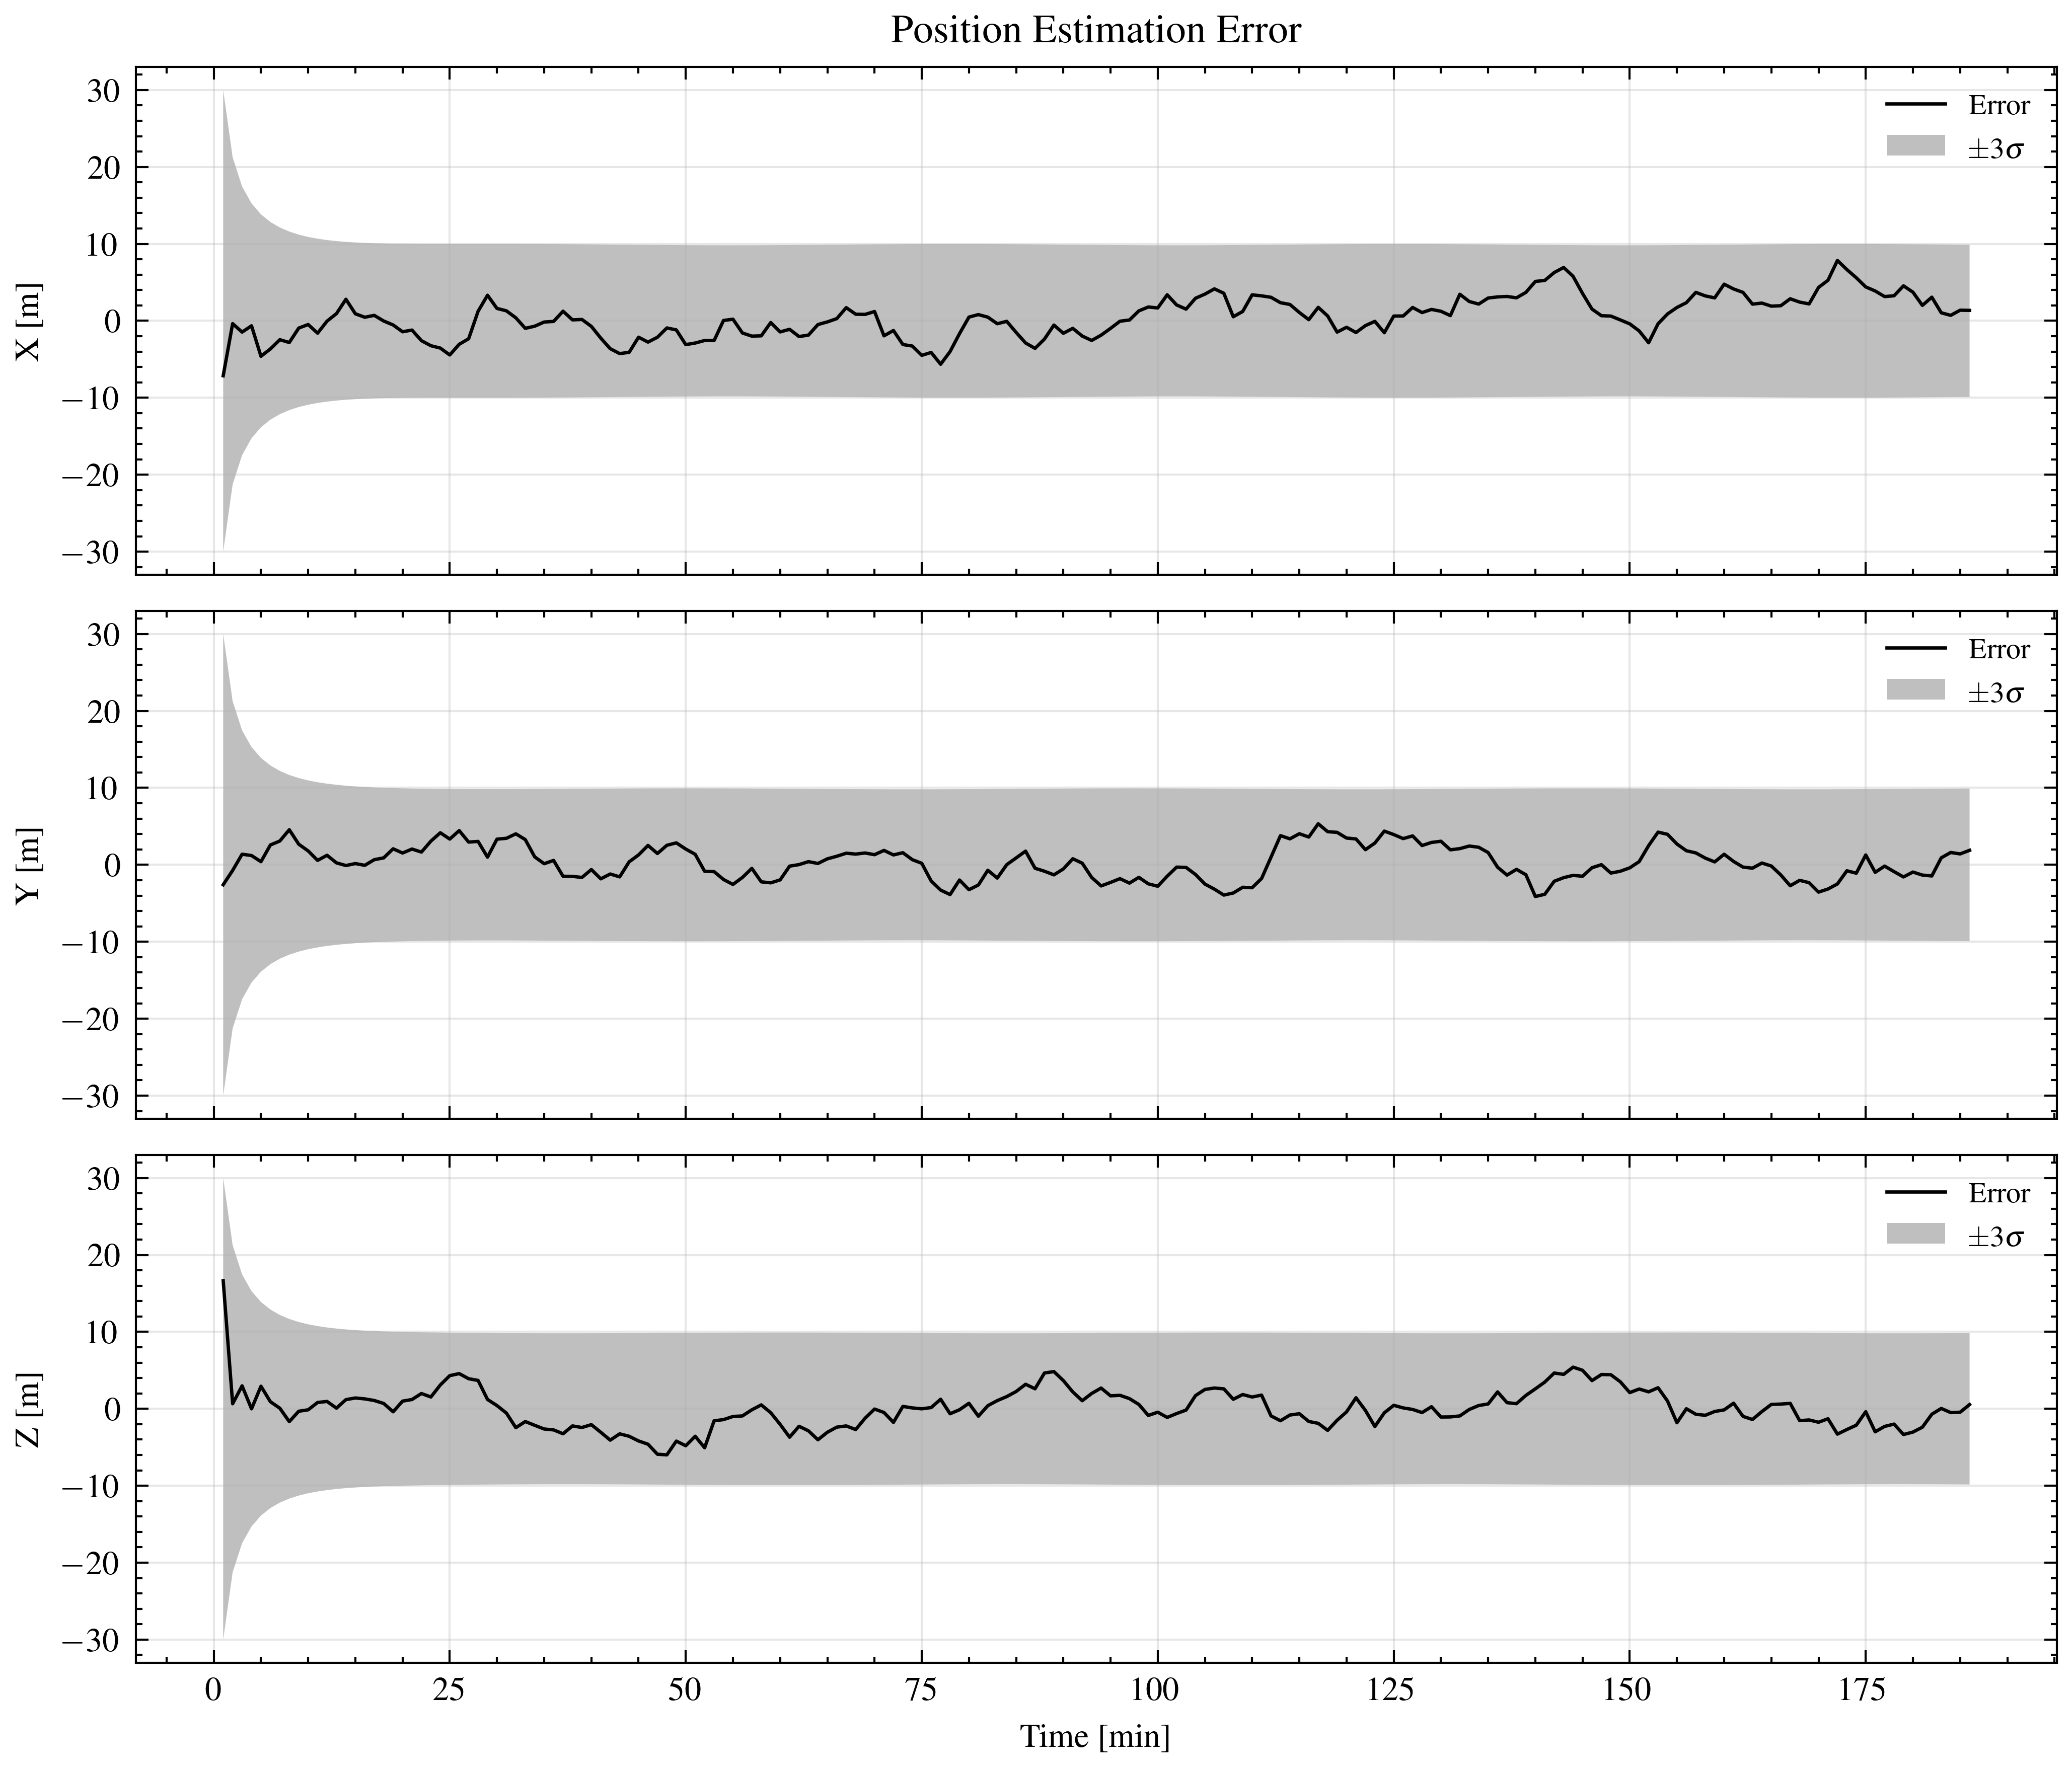

In [8]:
# Compute errors (filter estimate - truth)
pos_error = estimates[:, :3] - truth_states[1:, :3]  # (N_MEAS, 3)
vel_error = estimates[:, 3:] - truth_states[1:, 3:]  # (N_MEAS, 3)

# 3-sigma bounds from covariance diagonal
pos_3sigma = 3.0 * jnp.sqrt(P_diags[:, :3])  # (N_MEAS, 3)
vel_3sigma = 3.0 * jnp.sqrt(P_diags[:, 3:])  # (N_MEAS, 3)

# Time axis in minutes
t_min = meas_times[1:] / 60.0

labels = ["X", "Y", "Z"]

fig, axes = plt.subplots(3, 1, figsize=(7, 6), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(t_min, pos_error[:, i], linewidth=0.8, label="Error")
    ax.fill_between(
        t_min, -pos_3sigma[:, i], pos_3sigma[:, i],
        alpha=0.25, label=r"$\pm 3\sigma$"
    )
    ax.set_ylabel(f"{labels[i]} [m]")
    ax.legend(loc="upper right", fontsize=7)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Time [min]")
axes[0].set_title("Position Estimation Error")
fig.tight_layout()
plt.show()

### Velocity Error with 3$\sigma$ Covariance Bounds

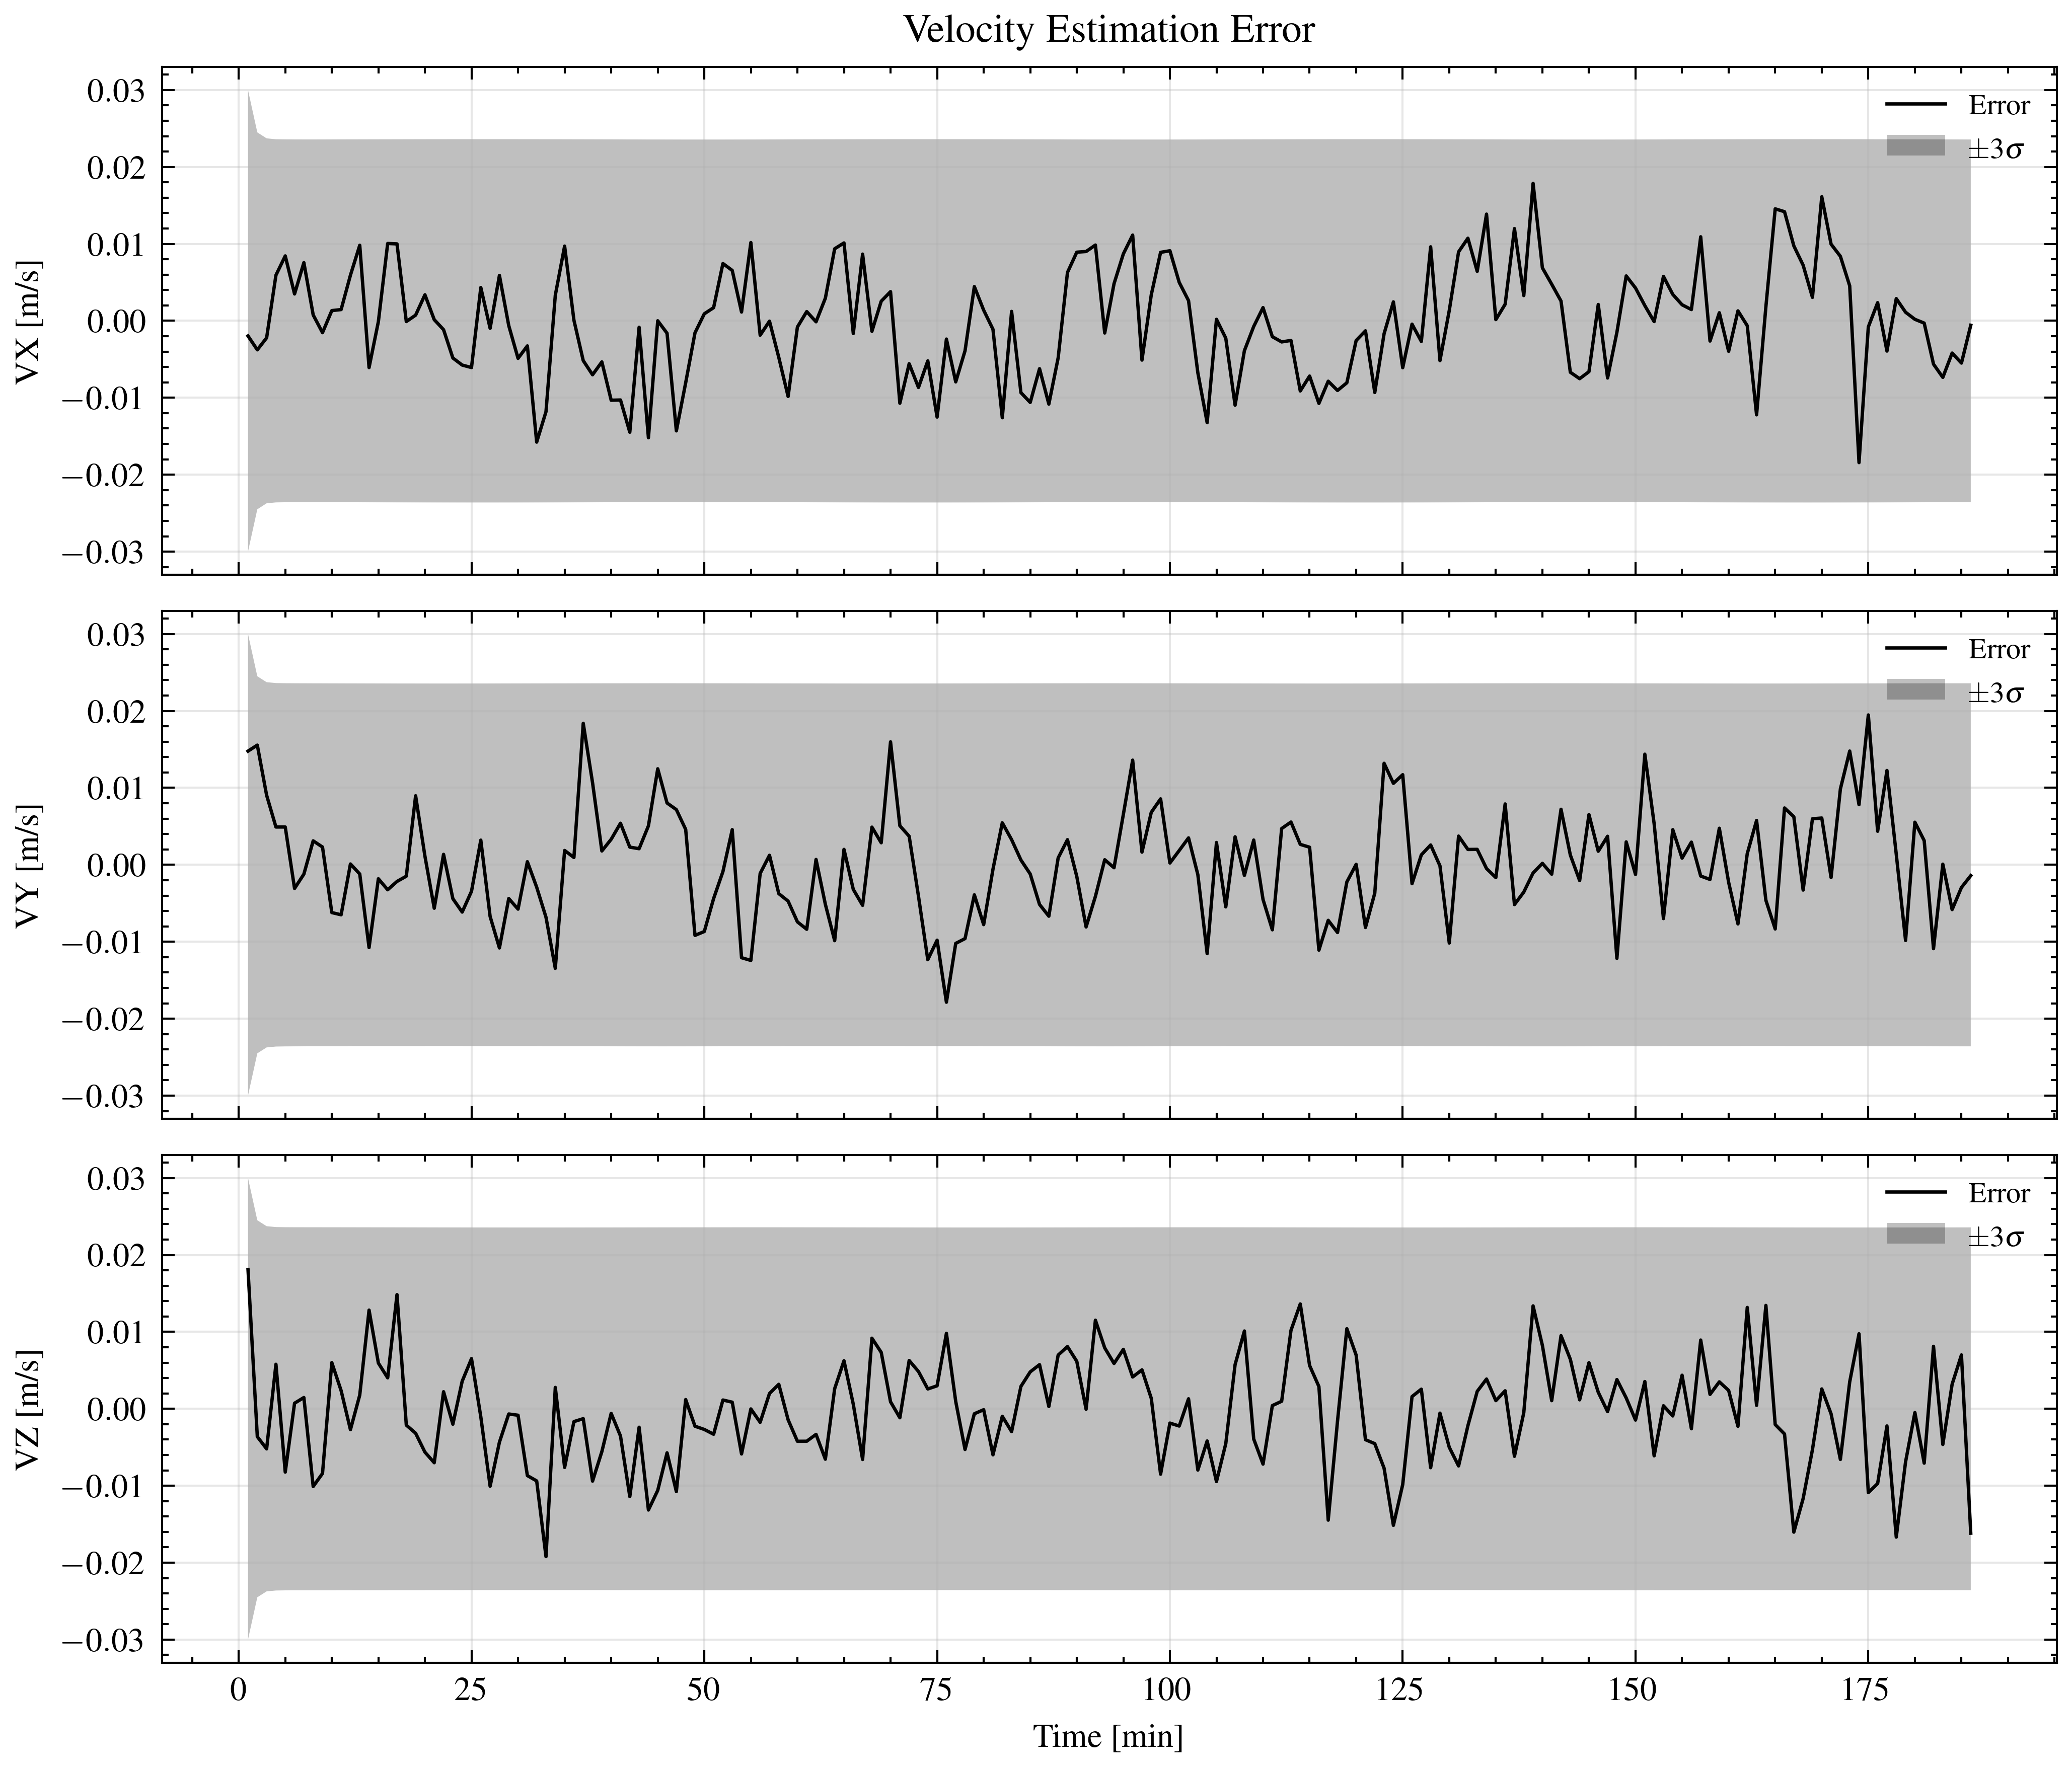

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(7, 6), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(t_min, vel_error[:, i], linewidth=0.8, label="Error")
    ax.fill_between(
        t_min, -vel_3sigma[:, i], vel_3sigma[:, i],
        alpha=0.25, label=r"$\pm 3\sigma$"
    )
    ax.set_ylabel(f"V{labels[i]} [m/s]")
    ax.legend(loc="upper right", fontsize=7)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Time [min]")
axes[0].set_title("Velocity Estimation Error")
fig.tight_layout()
plt.show()

### Pre-fit and Post-fit Residuals

Pre-fit residuals (before measurement incorporation) should be larger than post-fit residuals (after update). This confirms the filter is correctly incorporating measurements to reduce estimation error.

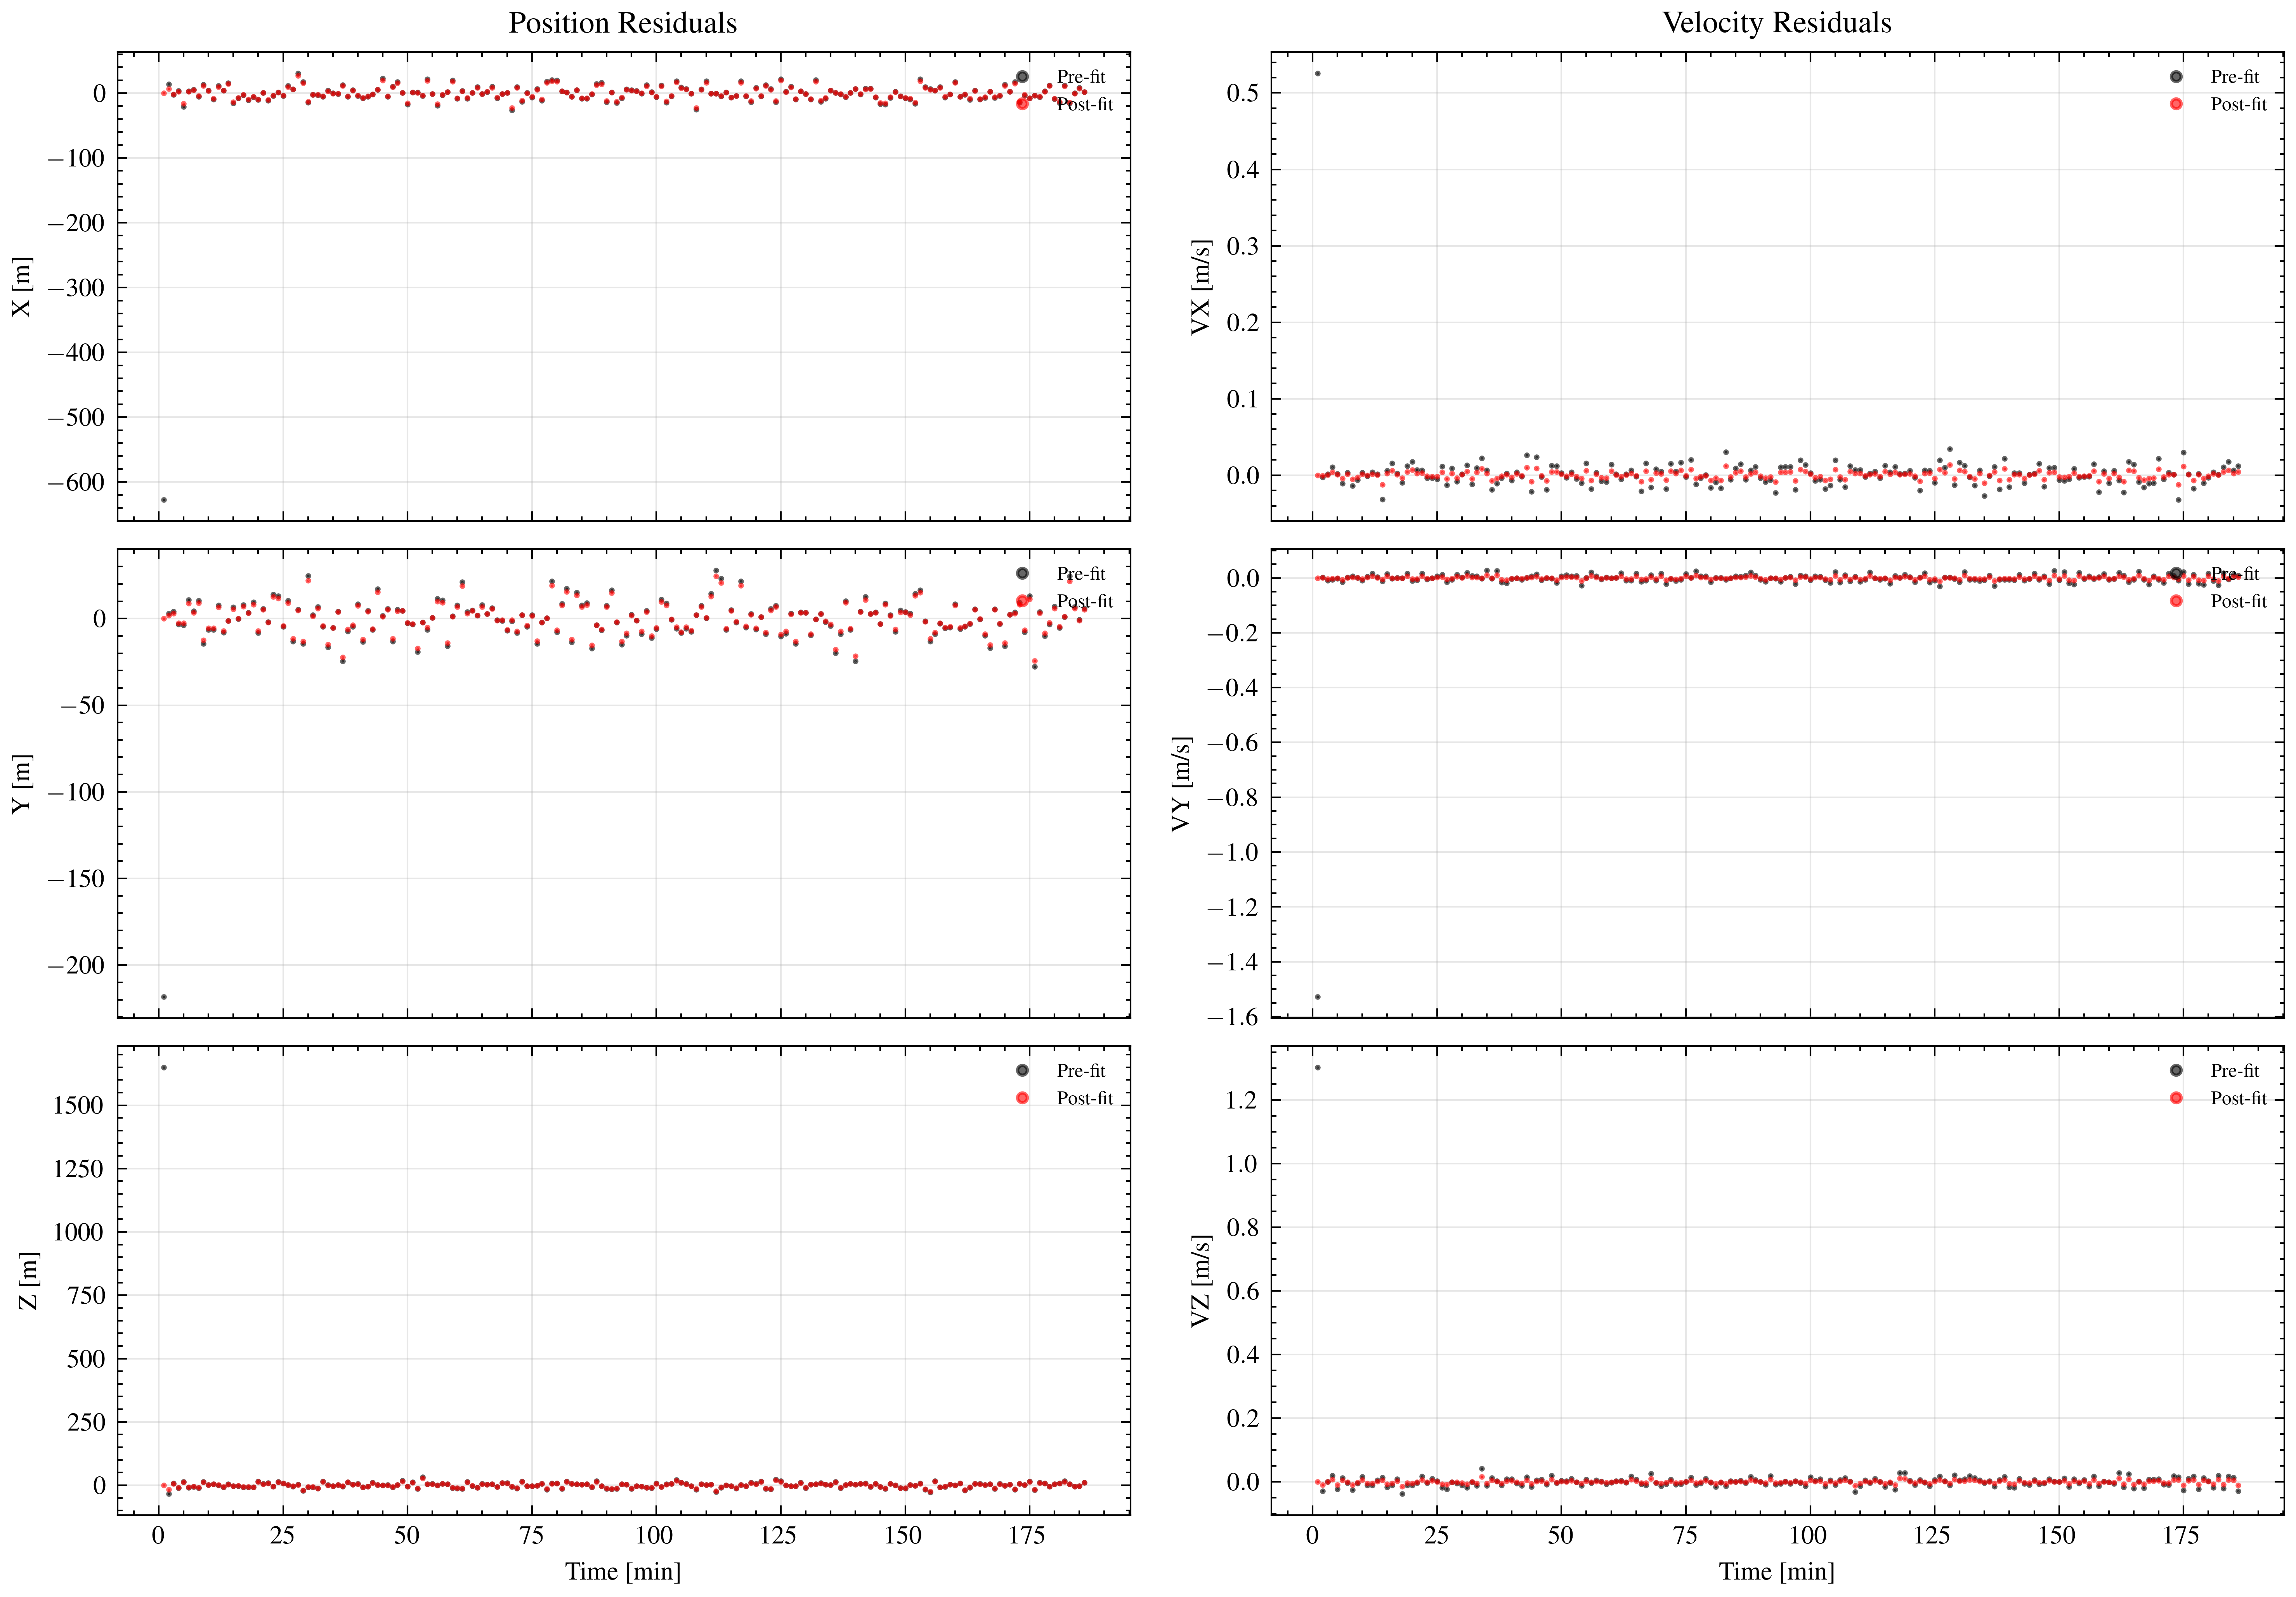

Pre-fit  position RMS: 75.95 m
Post-fit position RMS: 8.84 m
Pre-fit  velocity RMS: 0.0888 m/s
Post-fit velocity RMS: 0.0048 m/s


In [10]:
fig, axes = plt.subplots(3, 2, figsize=(10, 7), sharex=True)

# Position residuals (left column)
for i in range(3):
    ax = axes[i, 0]
    ax.plot(t_min, pre_fits[:, i], ".", markersize=1.5, alpha=0.6, label="Pre-fit")
    ax.plot(t_min, post_fits[:, i], ".", markersize=1.5, alpha=0.6, label="Post-fit")
    ax.set_ylabel(f"{labels[i]} [m]")
    ax.legend(loc="upper right", fontsize=6, markerscale=4)
    ax.grid(True, alpha=0.3)

# Velocity residuals (right column)
for i in range(3):
    ax = axes[i, 1]
    ax.plot(t_min, pre_fits[:, 3 + i], ".", markersize=1.5, alpha=0.6, label="Pre-fit")
    ax.plot(t_min, post_fits[:, 3 + i], ".", markersize=1.5, alpha=0.6, label="Post-fit")
    ax.set_ylabel(f"V{labels[i]} [m/s]")
    ax.legend(loc="upper right", fontsize=6, markerscale=4)
    ax.grid(True, alpha=0.3)

axes[-1, 0].set_xlabel("Time [min]")
axes[-1, 1].set_xlabel("Time [min]")
axes[0, 0].set_title("Position Residuals")
axes[0, 1].set_title("Velocity Residuals")
fig.tight_layout()
plt.show()

# Summary statistics
print(f"Pre-fit  position RMS: {jnp.sqrt(jnp.mean(pre_fits[:, :3]**2)):.2f} m")
print(f"Post-fit position RMS: {jnp.sqrt(jnp.mean(post_fits[:, :3]**2)):.2f} m")
print(f"Pre-fit  velocity RMS: {jnp.sqrt(jnp.mean(pre_fits[:, 3:]**2)):.4f} m/s")
print(f"Post-fit velocity RMS: {jnp.sqrt(jnp.mean(post_fits[:, 3:]**2)):.4f} m/s")